<a href="https://colab.research.google.com/github/tasaufmim/lungCancer3modelsCompare/blob/main/LungCancerVGG16ResNet50VGG19Rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

In [2]:
pip install pandas

In [3]:
pip install torchsummary

In [4]:
import opendatasets as od
import pandas
import os
import shutil
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
import torchvision.models as models
import pandas as pd

from PIL import Image, ImageEnhance
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from torchsummary import summary
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

In [5]:
#Downloading the dataset
od.download(
    "https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset")

Skipping, found downloaded files in "./iqothnccd-lung-cancer-dataset" (use force=True to force download)


In [6]:
#Checking the dataset
base_dir = '/content/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
class_names = ['Bengin cases', 'Malignant cases', 'Normal cases']

for class_name in class_names:
    class_folder = os.path.join(base_dir, class_name);
    files = [f for f in os.listdir(class_folder)]
    print(len(files))

120
561
416


In [7]:
#Reinitiate existing folder (if any)
output_dir = "/content/balanced_dataset"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

In [8]:
def show_sample_images_with_axes(folder_path, title, num_images=15):
    class_folders = [
        os.path.join(folder_path, class_name)
        for class_name in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, class_name))
    ]

    images = []
    for class_folder in class_folders:
        files = [f for f in os.listdir(class_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(files)
        for file in files:
            img_path = os.path.join(class_folder, file)
            label = os.path.basename(class_folder)
            images.append((img_path, label))
            if len(images) >= num_images:
                break
        if len(images) >= num_images:
            break

    rows, cols = 3, 5
    plt.figure(figsize=(18, 10))
    for i in range(num_images):
        img_path, label = images[i]
        img = Image.open(img_path).convert('RGB')
        width, height = img.size

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)

        # Set pixel axis
        ax.set_xticks(np.linspace(0, width, num=5, dtype=int))
        ax.set_yticks(np.linspace(0, height, num=5, dtype=int))

        ax.tick_params(axis='both', labelsize=6)
        ax.set_xlabel("Pixels (width)", fontsize=7)
        ax.set_ylabel("Pixels (height)", fontsize=7)

        ax.set_title(f"{label}\n{width}×{height}px", fontsize=9)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

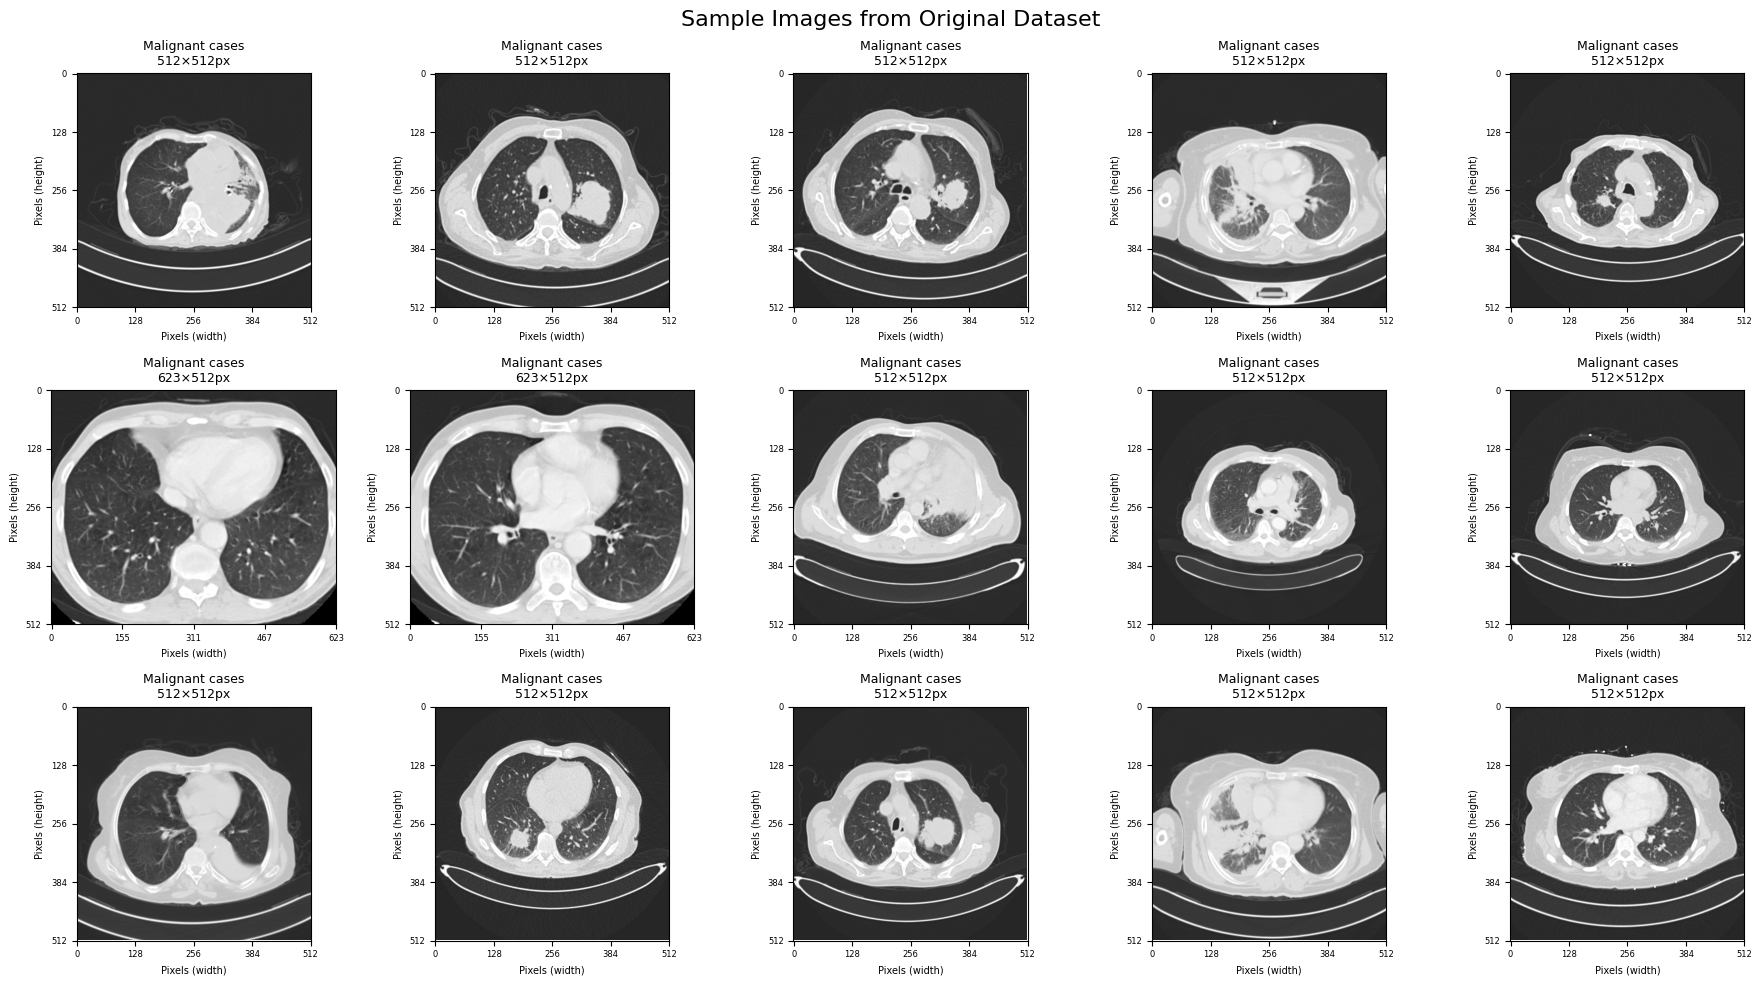

In [9]:
#Showing smaple images
show_sample_images_with_axes(base_dir, title="Sample Images from Original Dataset")

In [10]:
target_count = 600
img_size = (512, 512)

#Parameters of transformations
def get_random_transform():
    options = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
        lambda img: img.rotate(random.uniform(-25, 25)),
        lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(1.2, 1.8)),
        lambda img: ImageEnhance.Color(img).enhance(random.uniform(1.2, 2.0)),
        lambda img: ImageEnhance.Sharpness(img).enhance(random.uniform(1.5, 2.5))
    ]
    return random.choice(options)

def augment_and_save(class_name, target_count):
    class_src = os.path.join(base_dir, class_name)
    class_dst = os.path.join(output_dir, class_name)
    os.makedirs(class_dst)

    images = [f for f in os.listdir(class_src)]
    original_count = len(images)

    #copying to output folder
    for img in images:
        shutil.copy(os.path.join(class_src, img), os.path.join(class_dst, img))

    #Check if original_count < target_count
    extra_needed = target_count - original_count
    if extra_needed <= 0:
        return

    print(f"Will generate {extra_needed} new images for {class_name}")

    for i in range(extra_needed):
        img_name = random.choice(images)
        try:
            with Image.open(os.path.join(class_src, img_name)) as img:
                img = img.convert('RGB').resize(img_size)
                transformed_img = get_random_transform()(img)
                save_name = f"aug{i}_{img_name}"
                transformed_img.save(os.path.join(class_dst, save_name))
        except Exception as err:
            print(f"Error while augmenting: {err}")

for class_name in class_names:
    augment_and_save(class_name, target_count)

print("Augmentation completed")

Will generate 480 new images for Bengin cases
Will generate 39 new images for Malignant cases
Will generate 184 new images for Normal cases
Augmentation completed


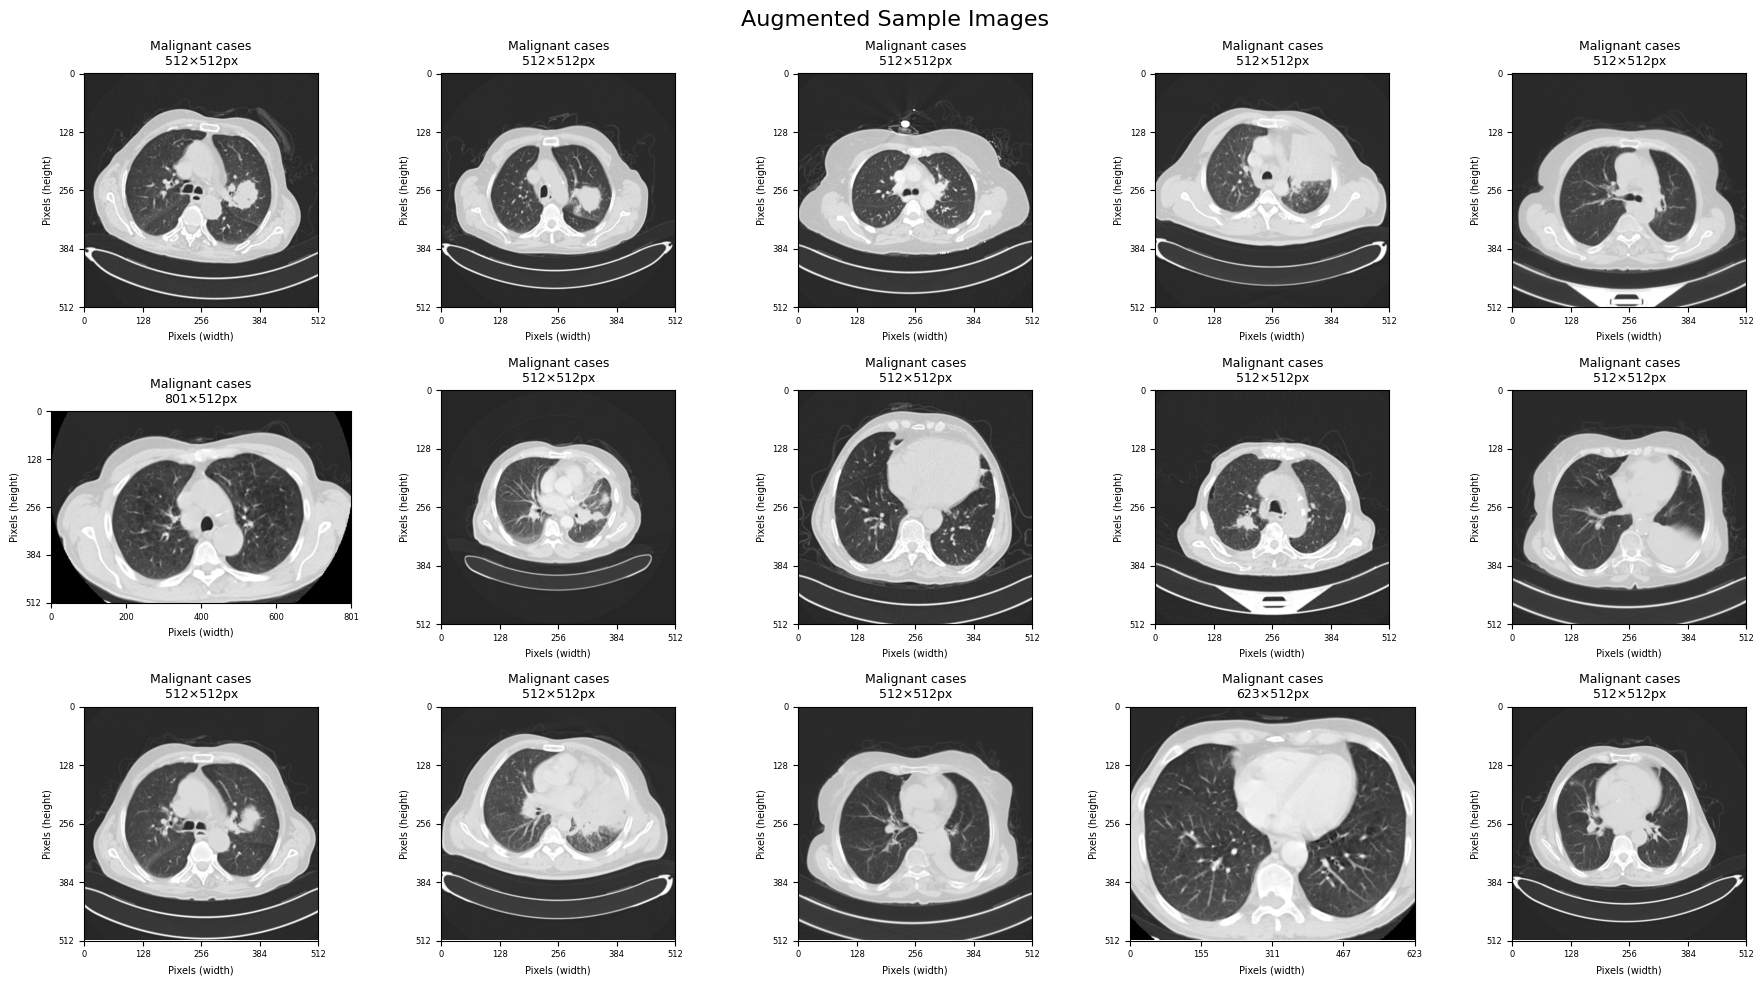

In [11]:
#Showing sample images after data augmentation
show_sample_images_with_axes(output_dir, title="Augmented Sample Images")

Training

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet means
                         [0.229, 0.224, 0.225])  # ImageNet std
])

dataset = datasets.ImageFolder(root="/content/balanced_dataset", transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)

#Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

#Replace the classifier
model.classifier[6] = nn.Linear(4096, 3)  #Number of classes: 3

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.1MB/s]


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg16_train_losses = []
vgg16_train_accuracies = []
vgg16_val_losses = []
vgg16_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg16_train_losses.append(epoch_loss)
    vgg16_train_accuracies.append(epoch_acc)

    #Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    vgg16_val_losses.append(val_loss / len(val_loader))
    vgg16_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {vgg16_val_losses[-1]:.4f}, Val Acc: {vgg16_val_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.5189, Train Acc: 0.7576, Val Loss: 0.2058, Val Acc: 0.9250
Epoch 2, Train Loss: 0.1714, Train Acc: 0.9396, Val Loss: 0.0984, Val Acc: 0.9667
Epoch 3, Train Loss: 0.0836, Train Acc: 0.9722, Val Loss: 0.0884, Val Acc: 0.9556
Epoch 4, Train Loss: 0.0875, Train Acc: 0.9694, Val Loss: 0.1283, Val Acc: 0.9528
Epoch 5, Train Loss: 0.0472, Train Acc: 0.9854, Val Loss: 0.0760, Val Acc: 0.9750
Epoch 6, Train Loss: 0.0256, Train Acc: 0.9931, Val Loss: 0.0593, Val Acc: 0.9750
Epoch 7, Train Loss: 0.0141, Train Acc: 0.9938, Val Loss: 0.0766, Val Acc: 0.9778
Epoch 8, Train Loss: 0.0081, Train Acc: 0.9979, Val Loss: 0.0617, Val Acc: 0.9889
Epoch 9, Train Loss: 0.0105, Train Acc: 0.9951, Val Loss: 0.0715, Val Acc: 0.9889
Epoch 10, Train Loss: 0.0098, Train Acc: 0.9972, Val Loss: 0.0599, Val Acc: 0.9806


In [15]:
#summary of the model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
#saving the trained model to output folder
#torch.save(model, 'vgg16_lung_cancer_model.pth')

Evaluation Metrics

In [17]:
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Converting to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

vgg16_y_true = y_true.copy()
vgg16_y_pred = y_pred.copy()

print("VGG16 Classification Report:")
print(classification_report(vgg16_y_true, vgg16_y_pred, target_names=class_names))

#Metrics calculation
sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

VGG16 Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.96      0.97      0.97       112
Malignant cases       1.00      1.00      1.00       131
   Normal cases       0.97      0.97      0.97       117

       accuracy                           0.98       360
      macro avg       0.98      0.98      0.98       360
   weighted avg       0.98      0.98      0.98       360



In [18]:
#Save to folder
vgg_metrics = {
    'Accuracy': round(sklearn_accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
}

print("VGG16 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

VGG16 Evaluation Metrics:
Accuracy: 0.9806
Precision: 0.9806
Recall: 0.9806
F1 Score: 0.9806


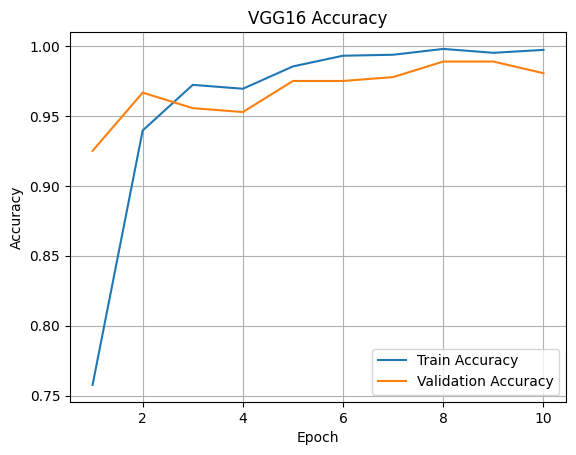

<Figure size 640x480 with 0 Axes>

In [19]:
#Accuracy plot
plt.plot(range(1, num_epochs+1), vgg16_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), vgg16_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG16 Accuracy")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('AccVal_acc')

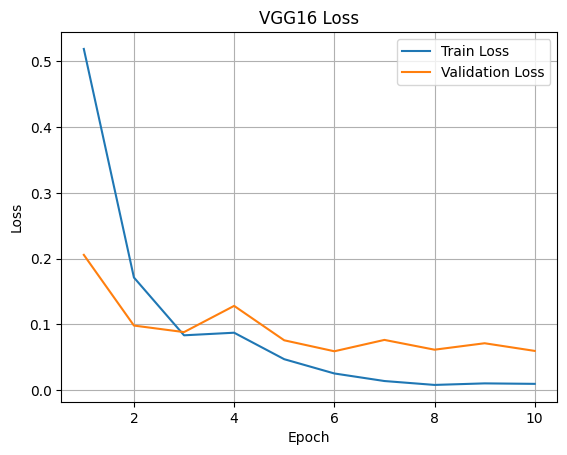

<Figure size 640x480 with 0 Axes>

In [20]:
#Loss plot
plt.plot(range(1, num_epochs+1), vgg16_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vgg16_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG16 Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('LossVal_loss')

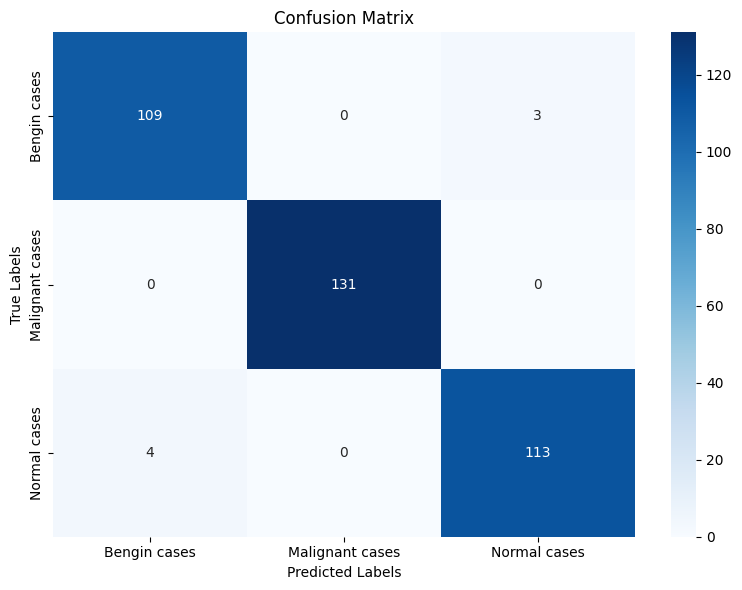

<Figure size 640x480 with 0 Axes>

In [21]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

#Plot Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.savefig('VGG16_confusion_matrix.png')

In [22]:
def plot_multiclass_roc(y_true, y_prob, n_classes, model_name):
    # Binarize the output
    y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8,6))
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{model_name}_ROC_Curve.png')

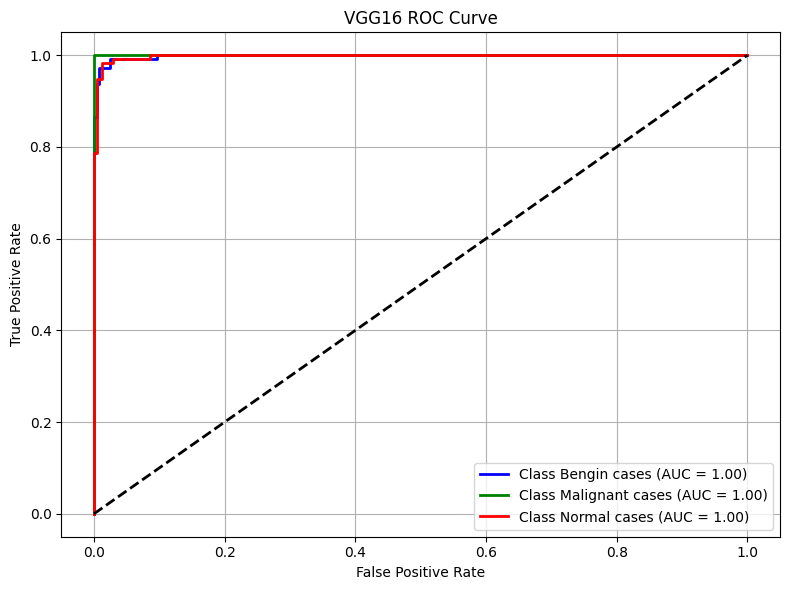

<Figure size 640x480 with 0 Axes>

In [23]:
# Get probabilities
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

vgg16_y_prob = np.array(all_probs)
vgg16_y_true = np.array(all_labels)

# Plot ROC
plot_multiclass_roc(vgg16_y_true, vgg16_y_prob, n_classes=3, model_name="VGG16")

ResNet50

In [24]:
##Training

#Laoding model
resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 3)

#movel to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

#Training loop
epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_acc)

    #Validation loop
    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    rn_val_losses.append(val_loss / len(val_loader))
    rn_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.3137, Train Acc: 0.8743, Val Loss: 0.0982, Val Acc: 0.9694
Epoch 2, Train Loss: 0.0436, Train Acc: 0.9882, Val Loss: 0.0468, Val Acc: 0.9861
Epoch 3, Train Loss: 0.0324, Train Acc: 0.9889, Val Loss: 0.0543, Val Acc: 0.9861
Epoch 4, Train Loss: 0.0199, Train Acc: 0.9951, Val Loss: 0.1330, Val Acc: 0.9639
Epoch 5, Train Loss: 0.0387, Train Acc: 0.9861, Val Loss: 0.0645, Val Acc: 0.9833
Epoch 6, Train Loss: 0.0164, Train Acc: 0.9944, Val Loss: 0.0595, Val Acc: 0.9861
Epoch 7, Train Loss: 0.0068, Train Acc: 0.9979, Val Loss: 0.0665, Val Acc: 0.9917
Epoch 8, Train Loss: 0.0082, Train Acc: 0.9972, Val Loss: 0.0815, Val Acc: 0.9806
Epoch 9, Train Loss: 0.0345, Train Acc: 0.9896, Val Loss: 0.1832, Val Acc: 0.9389
Epoch 10, Train Loss: 0.0157, Train Acc: 0.9944, Val Loss: 0.0492, Val Acc: 0.9944


In [ ]:
#summary of the model
summary(model, input_size=(3, 224, 224))

In [ ]:
#saving the trained model to output folder
#torch.save(model, 'resnet_lung_cancer_model.pth')

In [ ]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Converting to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

resnet_y_true = y_true.copy()
resnet_y_pred = y_pred.copy()

print("ResNet50 Classification Report:")
print(classification_report(resnet_y_true, resnet_y_pred, target_names=class_names))

#Metrics calculaiton
resnet_metrics = {
    'Accuracy': round(correct / total, 2),
    'Precision': round(precision_score(y_true, y_pred, average='weighted'), 4),
    'Recall': round(recall_score(y_true, y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(y_true, y_pred, average='weighted'), 4)
}

#Print results
print("ResNet50 Evaluation Metrics:")
for key, value in resnet_metrics.items():
    if key != 'Model':
        print(f"{key}: {value}")

#Accuracy plot
plt.plot(range(1, epochs+1), rn_train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), rn_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Loss plot
plt.plot(range(1, epochs+1), rn_train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), rn_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Get probabilities
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

resnet_y_prob = np.array(all_probs)
resnet_y_true = np.array(all_labels)

# Plot ROC
plot_multiclass_roc(resnet_y_true, resnet_y_prob, n_classes=3, model_name="ResNet50")


VGG19

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg19(pretrained=True)

#Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

#Replace the classifier
model.classifier[6] = nn.Linear(4096, 3)  #Number of classes: 3

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg19_train_losses = []
vgg19_train_accuracies = []
vgg19_val_losses = []
vgg19_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg19_train_losses.append(epoch_loss)
    vgg19_train_accuracies.append(epoch_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    vgg19_val_losses.append(val_loss / len(val_loader))
    vgg19_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {vgg19_val_losses[-1]:.4f}, Val Acc: {vgg19_val_accuracies[-1]:.4f}")

In [ ]:
#summary of the model
summary(model, input_size=(3, 224, 224))

In [ ]:
#saving the trained model to output folder
#torch.save(model, 'vgg19_lung_cancer_model.pth')

In [ ]:
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#converting to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

vgg19_y_true = y_true.copy()
vgg19_y_pred = y_pred.copy()

print("VGG19 Classification Report:")
print(classification_report(vgg19_y_true, vgg19_y_pred, target_names=class_names))

#metrics calculations
sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [ ]:
#Save to folder
vgg_metrics = {
    'Accuracy': round(sklearn_accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
}

print("VGG19 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

In [ ]:
# Accuracy plot
plt.plot(range(1, num_epochs+1), vgg19_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), vgg19_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Loss plot
plt.plot(range(1, num_epochs+1), vgg19_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vgg19_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
# Get probabilities
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

vgg19_y_prob = np.array(all_probs)
vgg19_y_true = np.array(all_labels)

# Plot ROC
plot_multiclass_roc(vgg19_y_true, vgg19_y_prob, n_classes=3, model_name="VGG19")


In [ ]:
# After evaluation of each model
vgg16_metrics = {
    'Model': 'VGG16',
    'Accuracy': round(accuracy_score(vgg16_y_true, vgg16_y_pred), 4),
    'Precision': round(precision_score(vgg16_y_true, vgg16_y_pred, average='weighted'), 4),
    'Recall': round(recall_score(vgg16_y_true, vgg16_y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(vgg16_y_true, vgg16_y_pred, average='weighted'), 4)
}

resnet_metrics = {
    'Model': 'ResNet50',
    'Accuracy': round(accuracy_score(resnet_y_true, resnet_y_pred), 4),
    'Precision': round(precision_score(resnet_y_true, resnet_y_pred, average='weighted'), 4),
    'Recall': round(recall_score(resnet_y_true, resnet_y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(resnet_y_true, resnet_y_pred, average='weighted'), 4)
}

vgg19_metrics = {
    'Model': 'VGG19',
    'Accuracy': round(accuracy_score(vgg19_y_true, vgg19_y_pred), 4),
    'Precision': round(precision_score(vgg19_y_true, vgg19_y_pred, average='weighted'), 4),
    'Recall': round(recall_score(vgg19_y_true, vgg19_y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(vgg19_y_true, vgg19_y_pred, average='weighted'), 4)
}

In [42]:
metrics_df = pd.DataFrame([vgg16_metrics, vgg19_metrics, resnet_metrics])
metrics_df.set_index("Model", inplace=True)

print("\nModel Performance Comparison:")
print(metrics_df)

metrics_df.to_csv("model_comparison_metrics.csv")


Model Performance Comparison:
          Accuracy  Precision  Recall  F1 Score
Model                                          
VGG16       0.9806     0.9806  0.9806    0.9806
VGG19       0.9806     0.9806  0.9806    0.9806
ResNet50    0.9944     0.9944  0.9944    0.9944


/tmp/ipython-input-41-1342094595.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=final_accuracies, palette='viridis')


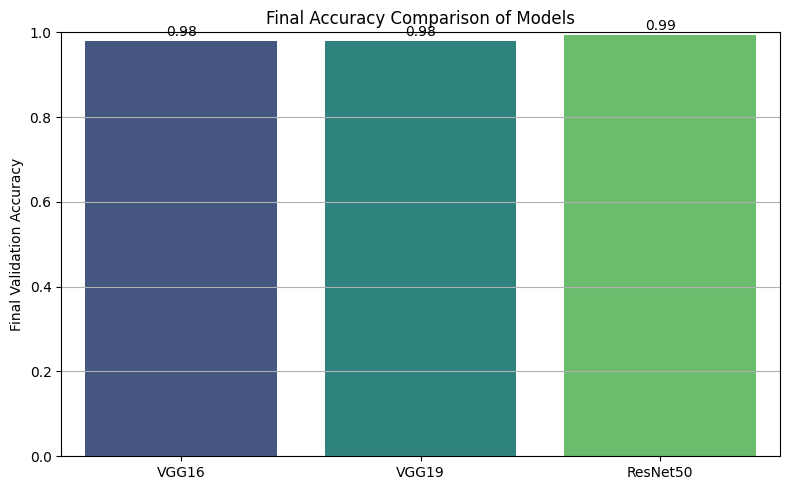

<Figure size 640x480 with 0 Axes>

In [41]:
# Final accuracy values
final_accuracies = [
    vgg16_val_accuracies[-1],
    vgg19_val_accuracies[-1],
    rn_val_accuracies[-1]
]
model_names = ['VGG16', 'VGG19', 'ResNet50']

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=final_accuracies, palette='viridis')
plt.ylabel("Final Validation Accuracy")
plt.ylim(0, 1)
plt.title("Final Accuracy Comparison of Models")
for i, acc in enumerate(final_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
plt.savefig('Final_Model_Accuracy_Comparison.png')